In [2]:
# import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from time import time
import jpholiday
import datetime as dt

def create_existing_data(train_src, test_src):
    train_df = train_src.copy()
    train_df = train_df.drop('y', axis='columns')
    test_df = test_src.copy()
    
    data = pd.concat([train_df, test_df])
    data = data[data.price_am != -1]
    data = data[data.price_pm != -1]
    data.set_index('datetime', inplace=True)
    return data
    
def create_non_existing_data(train_src, test_src):
    train_df = train_src.copy()
    train_df = train_df.drop('y', axis='columns')
    test_df = test_src.copy()
    
    data = pd.concat([train_df, test_df])
    data = data[(data.price_am == -1) | (data.price_pm == -1)]
    data.set_index('datetime', inplace=True)
    return data

def get_mean_am_of_same_day(existing_data, target_data):
    price_am_list = []
    price_pm_list = []
    price_am_list_prev = []
    price_pm_list_prev = []
    price_am_list_post = []
    price_pm_list_post = []
    for i in target_data.index:
        price_am = []
        price_pm = []
        price_am_prev = []
        price_pm_prev = []
        price_am_post = []
        price_pm_post = []
        prev_day = i + pd.DateOffset(days=-1)
        post_day = i + pd.DateOffset(days=1)
        
        for y in np.arange(2010, 2017):
            # for current day
            year = i.year
            month = i.month
            day = i.day
            if month == 2 and day == 29:
                day = 28
            if y != year and dt.datetime(y, month, day) in existing_data.index:
                price_am.append(existing_data.loc[dt.datetime(y, month, day), 'price_am'])
                price_pm.append(existing_data.loc[dt.datetime(y, month, day), 'price_pm'])
                
        for y in np.arange(2010, 2017):
            # for previous day
            year = prev_day.year
            month = prev_day.month
            day = prev_day.day
            if month == 2 and day == 29:
                day = 28
            if y != year and dt.datetime(y, month, day) in existing_data.index:
                price_am_prev.append(existing_data.loc[dt.datetime(y, month, day), 'price_am'])
                price_pm_prev.append(existing_data.loc[dt.datetime(y, month, day), 'price_pm'])
                
        for y in np.arange(2010, 2017):
            # for post day
            year = post_day.year
            month = post_day.month
            day = post_day.day
            if month == 2 and day == 29:
                day = 28
            if y != year and dt.datetime(y, month, day) in existing_data.index:
                price_am_post.append(existing_data.loc[dt.datetime(y, month, day), 'price_am'])
                price_pm_post.append(existing_data.loc[dt.datetime(y, month, day), 'price_pm'])
        
        if len(price_am) == 0:
            price_am_list.append(0)
        else:
            price_am_list.append(np.mean(price_am))
            
        if len(price_pm) == 0:
            price_pm_list.append(0)
        else:
            price_pm_list.append(np.mean(price_pm))
        
        if len(price_am_prev) == 0:
            price_am_list_prev.append(0)
        else:
            price_am_list_prev.append(np.mean(price_am_prev))
                  
        if len(price_pm_prev) == 0:
            price_pm_list_prev.append(0)
        else:
            price_pm_list_prev.append(np.mean(price_pm_prev))
                  
        if len(price_am_post) == 0:
            price_am_list_post.append(0)
        else:
            price_am_list_post.append(np.mean(price_am_post))
            
        if len(price_pm_post) == 0:
            price_pm_list_post.append(0)
        else:
            price_pm_list_post.append(np.mean(price_pm_post))
            
    return price_am_list, price_pm_list, price_am_list_prev, price_pm_list_prev, price_am_list_post, price_pm_list_post
    
def create_dataset_price_train(train_src, test_src):
    holiday = jpholiday.between(dt.date(2010, 7, 1), dt.date(2017, 3, 31))
    holiday = [x[0] for x in holiday]
    
    base_data = create_existing_data(train_src, test_src)
    base_data['Year'] = base_data.index.year
    base_data['Month'] = base_data.index.month
    base_data['Day'] = base_data.index.day
    base_data['DayOfWeek'] = base_data.index.dayofweek
    base_data['WeekOfYear'] = base_data.index.isocalendar().week
    base_data['JpHoliday'] = [1 if d.date() in holiday else 0 for d in base_data.index]
    price_am_list, price_pm_list, price_am_list_prev, price_pm_list_prev, price_am_list_post, price_pm_list_post = get_mean_am_of_same_day(base_data, base_data)
    base_data['MeanPriceAMOfSameDayInOtherYear'] = price_am_list
    base_data['MeanPricePMOfSameDayInOtherYear'] = price_pm_list
    base_data['MeanPriceAMOfPreviousDayInOtherYear'] = price_am_list_prev
    base_data['MeanPricePMOfPreviousDayInOtherYear'] = price_pm_list_prev
    base_data['MeanPriceAMOfPostDayInOtherYear'] = price_am_list_post
    base_data['MeanPricePMOfPostDayInOtherYear'] = price_pm_list_post
    
    return base_data

def create_dataset_price_test(train_src, test_src):
    holiday = jpholiday.between(dt.date(2010, 7, 1), dt.date(2017, 3, 31))
    holiday = [x[0] for x in holiday]
    
    lib_data = create_existing_data(train_src, test_src)
    base_data = create_non_existing_data(train_src, test_src)
    base_data['Year'] = base_data.index.year
    base_data['Month'] = base_data.index.month
    base_data['Day'] = base_data.index.day
    base_data['DayOfWeek'] = base_data.index.dayofweek
    base_data['WeekOfYear'] = base_data.index.isocalendar().week
    base_data['JpHoliday'] = [1 if d.date() in holiday else 0 for d in base_data.index]
    price_am_list, price_pm_list, price_am_list_prev, price_pm_list_prev, price_am_list_post, price_pm_list_post = get_mean_am_of_same_day(lib_data, base_data)
    base_data['MeanPriceAMOfSameDayInOtherYear'] = price_am_list
    base_data['MeanPricePMOfSameDayInOtherYear'] = price_pm_list
    base_data['MeanPriceAMOfPreviousDayInOtherYear'] = price_am_list_prev
    base_data['MeanPricePMOfPreviousDayInOtherYear'] = price_pm_list_prev
    base_data['MeanPriceAMOfPostDayInOtherYear'] = price_am_list_post
    base_data['MeanPricePMOfPostDayInOtherYear'] = price_pm_list_post
    X_test_price = base_data.drop(['price_am', 'price_pm'], axis='columns')
    
    return X_test_price


In [6]:
# read data
train = pd.read_csv("./train.csv",parse_dates=[0], low_memory=False)
test = pd.read_csv("./test.csv",parse_dates=[0], low_memory=False)
# predict price_am and price_pm
X_train_price = create_dataset_price_train(train, test)
X_test_price = create_dataset_price_test(train, test)

In [10]:
import torch
torch.set_float32_matmul_precision('high')

from autogluon.tabular import TabularDataset, TabularPredictor
predictor_price_am = TabularPredictor(label='price_am').fit(
    X_train_price.drop(columns=['price_pm']),
    hyperparameters='multimodal',
    presets='best_quality',
    num_stack_levels=1,
    num_bag_folds=5,
    refit_full=True,
    set_best_to_refit_full=True
    )

No path specified. Models will be saved in: "AutogluonModels\ag-20230819_223718\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
Cannot interpret 'UInt32Dtype()' as a data type
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230819_223718\"
AutoGluon Version:  0.8.2
Python Version:     3.9.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19044
Disk Space Avail:   10.10 GB / 510.77 GB (2.0%)
Train Data Rows:    2249
Train Data Columns: 14
Label Column: price_am
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	6 unique label values:  [0, 1, 2, 3, 5, 4]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multic

2023-08-20 07:39:07,012	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2023-08-20 07:39:07,019	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2023-08-20 07:39:07,027	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
	0.7843	 = Validation score   (accuracy)
	16.28s	 = Training   runtime
	0.3s	 = Validation runtime
Fitting model: MultiModalPredictor_BAG_L1 ...
		Unable to convert function return value to a Python type! The signature was
	() -> handle
Detailed Traceback:
Traceback (most recent call last):
  File "C:\Users\10021\Anac

Fitting model: WeightedEnsemble_L2 ...
	0.8004	 = Validation score   (accuracy)
	0.43s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 6 L2 models ...
Fitting model: LightGBM_BAG_L2 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
	0.7897	 = Validation score   (accuracy)
	17.05s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
	0.7906	 = Validation score   (accuracy)
	11.67s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
	0.7981	 = Validation score   (accuracy)
	82.12s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost_BAG_L2 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
	0.7892	 = Validation score   (accuracy)
	14.63s	 = Tra

In [11]:
predictor_price_pm = TabularPredictor(label='price_pm').fit(
    X_train_price.drop(columns=['price_am']),
    hyperparameters='multimodal',
    presets='best_quality',
    num_stack_levels=1,
    num_bag_folds=5,
    refit_full=True,
    set_best_to_refit_full=True
    )


No path specified. Models will be saved in: "AutogluonModels\ag-20230819_224503\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
Cannot interpret 'UInt32Dtype()' as a data type
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230819_224503\"
AutoGluon Version:  0.8.2
Python Version:     3.9.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19044
Disk Space Avail:   9.85 GB / 510.77 GB (1.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    2249
Train Data Columns: 14
Label Column: price_pm
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	6 unique label values:  [0, 1, 2, 3, 4, 5]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type 

	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
2023-08-20 07:47:01,765	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2023-08-20 07:47:01,772	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2023-08-20 07:47:01,778	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2023-08-20 07:47:01,785	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
	0.839

Fitting model: WeightedEnsemble_L2 ...
	0.8439	 = Validation score   (accuracy)
	0.43s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 6 L2 models ...
Fitting model: LightGBM_BAG_L2 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
	0.8337	 = Validation score   (accuracy)
	19.62s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
	0.8333	 = Validation score   (accuracy)
	12.55s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
	0.8404	 = Validation score   (accuracy)
	75.07s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost_BAG_L2 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
	0.8328	 = Validation score   (accuracy)
	14.62s	 = Tr

In [12]:
preds_price_am = predictor_price_am.predict(X_test_price)

In [13]:
preds_price_pm = predictor_price_pm.predict(X_test_price)

In [77]:
def fix_missing_value(target_data, preds_price_am, preds_price_pm):
    for index, row in target_data.iterrows():
        if row['price_am'] == -1:
            target_data.at[index, 'price_am'] = preds_price_am[row['datetime']]
        if row['price_pm'] == -1:
            target_data.at[index, 'price_pm'] = preds_price_pm[row['datetime']]
    return target_data

train = pd.read_csv("./train.csv",parse_dates=[0], low_memory=False)
test = pd.read_csv("./test.csv",parse_dates=[0], low_memory=False)
fixed_train = fix_missing_value(train, preds_price_am, preds_price_pm)
fixed_train['datetime'] = pd.to_datetime(fixed_train['datetime'])
fixed_train.set_index('datetime', inplace=True)
fixed_test = fix_missing_value(test, preds_price_am, preds_price_pm)
fixed_test['datetime'] = pd.to_datetime(fixed_test['datetime'])
fixed_test.set_index('datetime', inplace=True)

<AxesSubplot:xlabel='datetime'>

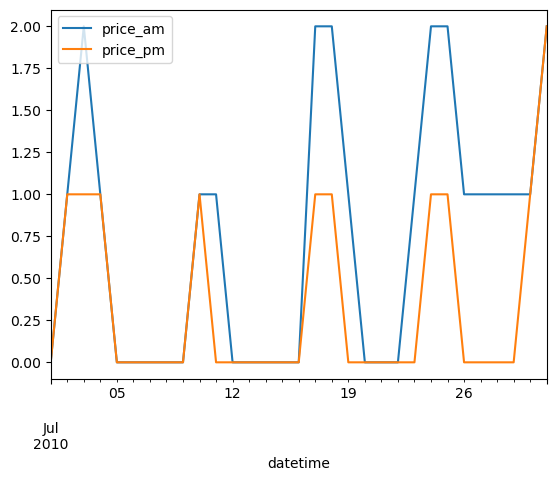

In [76]:
fixed_train.loc['2010-07-01':'2010-07-31', ['price_am', 'price_pm']].plot(kind='line')

In [79]:
print(fixed_train['price_am'].value_counts())
print(fixed_train['price_pm'].value_counts())
print(fixed_test['price_am'].value_counts())
print(fixed_test['price_pm'].value_counts())

0    1065
1     654
2     274
3      46
4      33
5      29
Name: price_am, dtype: int64
0    1345
1     549
2     130
3      34
4      30
5      13
Name: price_pm, dtype: int64
0    168
1    129
2     51
3      7
4      6
5      4
Name: price_am, dtype: int64
0    215
1    111
2     22
4      8
3      6
5      3
Name: price_pm, dtype: int64


In [84]:
def features_create(src):  
    holiday = jpholiday.between(dt.date(2010, 7, 1), dt.date(2017, 3, 31))
    holiday = [x[0] for x in holiday]
    data = src.copy()

    # normal features
    data['Year'] = data.index.year
    data['Month'] = data.index.month
    data['Day'] = data.index.day
    data['DayOfWeek'] = data.index.dayofweek
    data['WeekOfYear'] = data.index.isocalendar().week
    data['JpHoliday'] = [1 if d.date() in holiday else 0 for d in data.index]

    data['oneday_before_am'] = data['price_am'].shift(1)
    data['oneday_before_pm'] = data['price_pm'].shift(1)
    data['rel_3am'] = data['price_am'].rolling(7).sum()
    data['rel_3pm'] = data['price_pm'].rolling(7).sum()
    data['rel_3cli'] = data['client'].rolling(7).sum()
    data['rel_3clo'] = data['close'].rolling(7).sum()

    # features for time series
    data.sort_values(['datetime'],ascending = True, inplace=True)
    
    return data

X_train_y = features_create(fixed_train)
X_test_y = features_create(fixed_test)

In [85]:
predictor_y = TabularPredictor(label='y').fit(
    X_train_y,
    hyperparameters='multimodal',
    presets='best_quality',
    num_stack_levels=1,
    num_bag_folds=5,
    refit_full=True,
    set_best_to_refit_full=True
    )

No path specified. Models will be saved in: "AutogluonModels\ag-20230819_235617\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
Cannot interpret 'UInt32Dtype()' as a data type
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230819_235617\"
AutoGluon Version:  0.8.2
Python Version:     3.9.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19044
Disk Space Avail:   9.61 GB / 510.77 GB (1.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    2101
Train Data Columns: 16
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	First 10 (of 99) unique label values:  [17, 18, 20, 14, 4, 10, 12, 21, 15, 11]
	If 'multiclass' is not the correct problem_type, please manua

Fitting model: LightGBMLarge_BAG_L1 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
2023-08-20 09:00:09,707	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2023-08-20 09:00:09,714	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2023-08-20 09:00:09,720	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2023-08-20 09:00:09,726	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-

Fitting model: WeightedEnsemble_L2 ...
	0.0883	 = Validation score   (accuracy)
	2.81s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 6 L2 models ...
Fitting model: LightGBM_BAG_L2 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
	0.0707	 = Validation score   (accuracy)
	944.99s	 = Training   runtime
	1.2s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
	0.0737	 = Validation score   (accuracy)
	499.32s	 = Training   runtime
	0.38s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
	0.0785	 = Validation score   (accuracy)
	11993.2s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: XGBoost_BAG_L2 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
	0.0732	 = Validation score   (accuracy)
	842.75s	 

In [99]:
preds_y = predictor_y.predict(X_test_y)
preds_y.to_csv('submissionMM.csv', index=True, header=False)

datetime
2016-04-01    45
2016-04-02    45
2016-04-03    45
2016-04-04    45
2016-04-05    31
              ..
2017-03-27    88
2017-03-28    88
2017-03-29    88
2017-03-30    88
2017-03-31    69
Name: y, Length: 365, dtype: int64


In [104]:
X_train_y = X_train_y.astype({"y": float})
print(X_train_y.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2101 entries, 2010-07-01 to 2016-03-31
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   y                 2101 non-null   float64
 1   client            2101 non-null   int64  
 2   close             2101 non-null   int64  
 3   price_am          2101 non-null   int64  
 4   price_pm          2101 non-null   int64  
 5   Year              2101 non-null   int64  
 6   Month             2101 non-null   int64  
 7   Day               2101 non-null   int64  
 8   DayOfWeek         2101 non-null   int64  
 9   WeekOfYear        2101 non-null   UInt32 
 10  JpHoliday         2101 non-null   int64  
 11  oneday_before_am  2100 non-null   float64
 12  oneday_before_pm  2100 non-null   float64
 13  rel_3am           2095 non-null   float64
 14  rel_3pm           2095 non-null   float64
 15  rel_3cli          2095 non-null   float64
 16  rel_3clo          2095 n

<AxesSubplot:xlabel='datetime'>

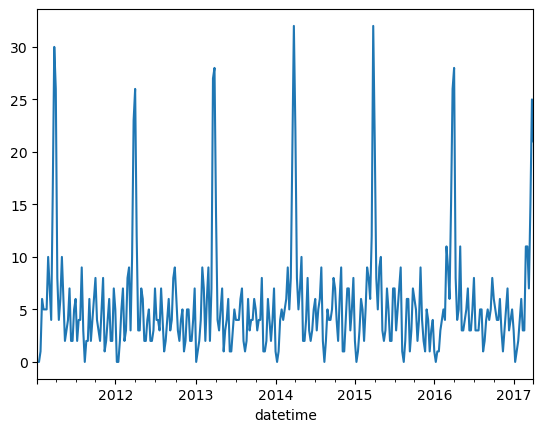

In [120]:
#X_train_price = create_dataset_price_train(train, test)
#X_test_price = create_dataset_price_test(train, test)
X_train_price['price_am'].resample('W').sum().plot(kind='line')


<AxesSubplot:xlabel='datetime'>

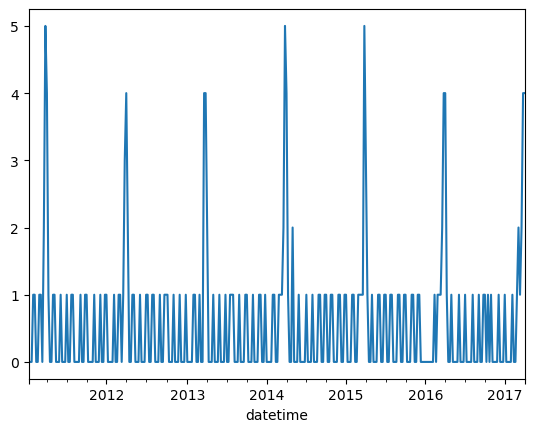

In [114]:
X_train_price['price_am'].resample('W').median().plot(kind='line')

<AxesSubplot:xlabel='datetime'>

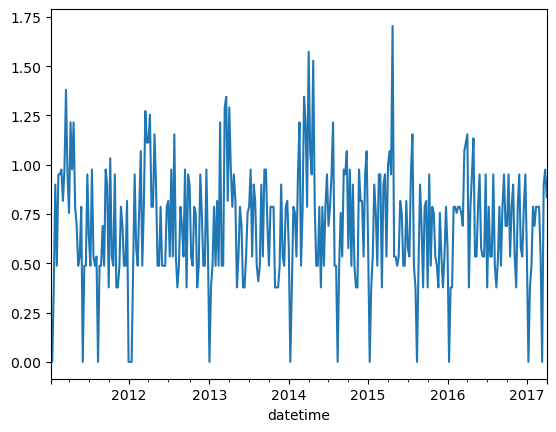

In [115]:
X_train_price['price_am'].resample('W').std().plot(kind='line')

<AxesSubplot:xlabel='datetime'>

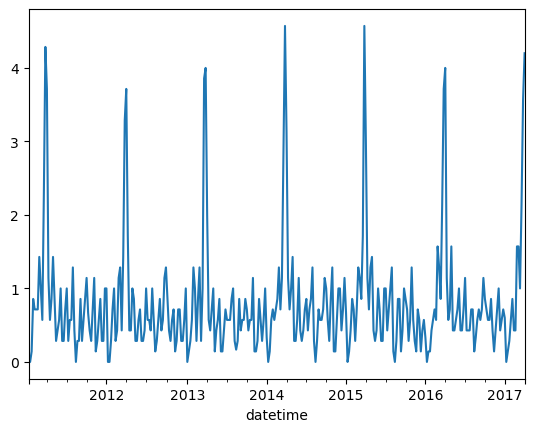

In [116]:
X_train_price['price_am'].resample('W').mean().plot(kind='line')

<AxesSubplot:xlabel='datetime'>

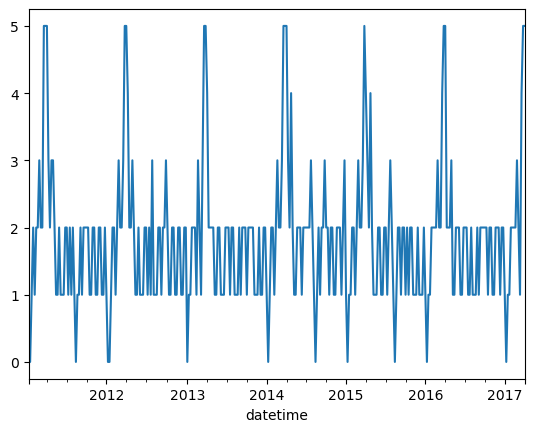

In [117]:
X_train_price['price_am'].resample('W').max().plot(kind='line')

In [33]:
train = pd.read_csv("./train.csv",parse_dates=[0], low_memory=False)
test = pd.read_csv("./test.csv",parse_dates=[0], low_memory=False)
train['datetime'] = pd.to_datetime(train['datetime'])
train.set_index('datetime', inplace=True)
test['datetime'] = pd.to_datetime(test['datetime'])
test.set_index('datetime', inplace=True)
#print(train['price_am'].value_counts()) # 211 -1  # a(187) at head
#print(train['price_pm'].value_counts()) # 212 -1  # a(187) at head
#print(train[train['price_am'] == -1].tail(40)) # Only 2011-07-01  16       0      0        -1        -1 
#print(train[train['price_pm'] == -1].tail(40))  # Only 2011-07-01 and 2011-10-03  20       0      0         1        -1
#print(train[train['close'] == 1].tail(27)) # b(27) items which does not need prediction when close is 1, c(4) items is overlapped with a
#print(test['price_am'].value_counts()) # 5 -1 which does not need prediction all when close is 1
#print(test['price_pm'].value_counts()) # 5 -1 which does not need prediction all when close is 1
#print(test[test['price_am'] == -1].tail(6))

In [36]:
holiday = jpholiday.between(dt.date(2010, 7, 1), dt.date(2017, 3, 31))
holiday = [x[0] for x in holiday]
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['DayOfYear'] = train.index.dayofyear
train['DayOfWeek'] = train.index.dayofweek
train['Quarter'] = train.index.quarter
train['WeekOfYear'] = train.index.isocalendar().week
train['JpHoliday'] = [1 if d.date() in holiday else 0 for d in train.index]
train['oneday_before_am'] = train['price_am'].shift(1)
train['oneday_before_pm'] = train['price_pm'].shift(1)
train['rel_3am'] = train['price_am'].rolling(7).sum()
train['rel_3pm'] = train['price_pm'].rolling(7).sum()
train['rel_3cli'] = train['client'].rolling(7).sum()
train['rel_3clo'] = train['close'].rolling(7).sum()

train = train[(train.price_am != -1) & (train.price_pm != -1)]

#plt.subplots(figsize=(24,20))
#sns.heatmap(train.corr(),annot=True, vmin=-0.1, vmax=0.1,center=0)
train.tail(100)

,y,client,close,price_am,price_pm,Year,Month,Day,DayOfYear,DayOfWeek,Quarter,WeekOfYear,JpHoliday,oneday_before_am,oneday_before_pm,rel_3am,rel_3pm,rel_3cli,rel_3clo
datetime,,,,,,,,,,,,,,,,,,,
2015-12-19,63,1,0,1,1,2015,12,19,353,5,4,51,0,1.0,0.0,2.0,1.0,7.0,0.0
2015-12-20,58,1,0,1,1,2015,12,20,354,6,4,51,0,1.0,1.0,3.0,2.0,7.0,0.0
2015-12-21,65,1,0,0,0,2015,12,21,355,0,4,52,0,1.0,1.0,3.0,2.0,7.0,0.0
2015-12-22,61,1,0,0,0,2015,12,22,356,1,4,52,0,0.0,0.0,3.0,2.0,7.0,0.0
2015-12-23,71,1,0,0,0,2015,12,23,357,2,4,52,1,0.0,0.0,3.0,2.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-27,94,1,0,5,4,2016,3,27,87,6,1,12,0,5.0,5.0,26.0,27.0,6.0,0.0
2016-03-28,86,1,0,4,4,2016,3,28,88,0,1,13,0,5.0,4.0,27.0,28.0,6.0,0.0
2016-03-29,98,1,0,4,4,2016,3,29,89,1,1,13,0,4.0,4.0,27.0,28.0,7.0,0.0


(2101, 5)


<AxesSubplot:xlabel='datetime'>

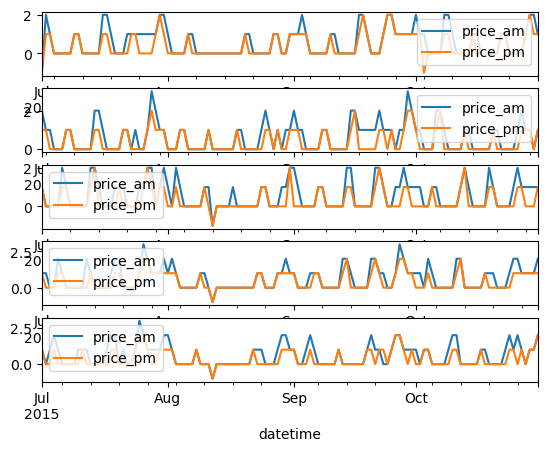

In [32]:
print(train.shape)

#train.loc['2011-07-01':'2011-10-31', ['price_am', 'price_pm']].plot(kind='line')

fig, axes = plt.subplots(nrows=5, ncols=1)

train.loc['2011-07-01':'2011-10-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[0])
train.loc['2012-07-01':'2012-10-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[1])
train.loc['2013-07-01':'2013-10-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[2])
train.loc['2014-07-01':'2014-10-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[3])
train.loc['2015-07-01':'2015-10-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[4])

<AxesSubplot:xlabel='datetime'>

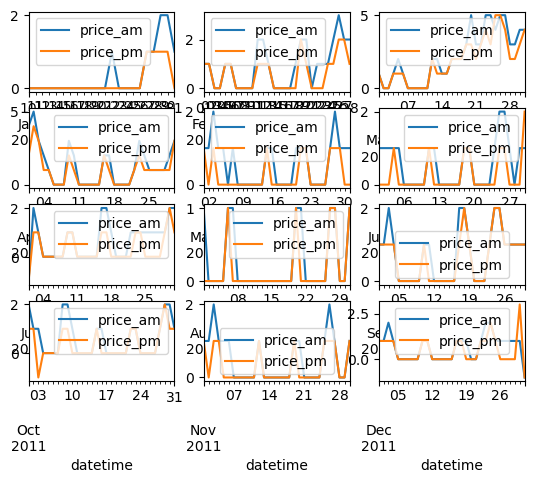

In [35]:
fig, axes = plt.subplots(nrows=4, ncols=3)

df_train.loc['2011-01-10':'2011-01-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[0,0])
df_train.loc['2011-02-01':'2011-02-28', ['price_am', 'price_pm']].plot(kind='line', ax=axes[0,1])
df_train.loc['2011-03-01':'2011-03-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[0,2])
df_train.loc['2011-04-01':'2011-04-30', ['price_am', 'price_pm']].plot(kind='line', ax=axes[1,0])
df_train.loc['2011-05-01':'2011-05-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[1,1])
df_train.loc['2011-06-01':'2011-06-30', ['price_am', 'price_pm']].plot(kind='line', ax=axes[1,2])
df_train.loc['2011-07-01':'2011-07-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[2,0])
df_train.loc['2011-08-01':'2011-08-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[2,1])
df_train.loc['2011-09-01':'2011-09-30', ['price_am', 'price_pm']].plot(kind='line', ax=axes[2,2])
df_train.loc['2011-10-01':'2011-10-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[3,0])
df_train.loc['2011-11-01':'2011-11-30', ['price_am', 'price_pm']].plot(kind='line', ax=axes[3,1])
df_train.loc['2011-12-01':'2011-12-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[3,2])

<AxesSubplot:xlabel='datetime'>

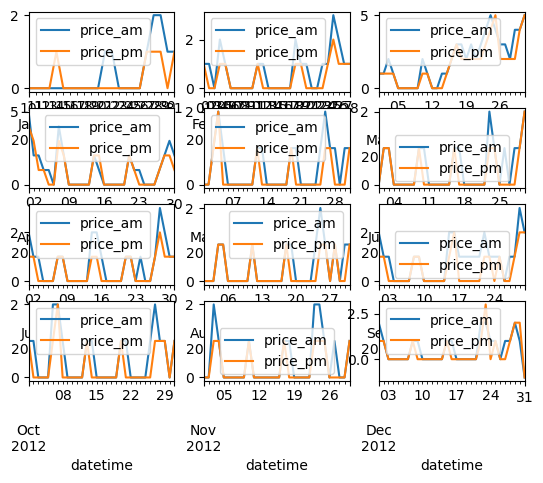

In [39]:
fig, axes = plt.subplots(nrows=4, ncols=3)

df_train.loc['2012-01-10':'2012-01-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[0,0])
df_train.loc['2012-02-01':'2012-02-28', ['price_am', 'price_pm']].plot(kind='line', ax=axes[0,1])
df_train.loc['2012-03-01':'2012-03-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[0,2])
df_train.loc['2012-04-01':'2012-04-30', ['price_am', 'price_pm']].plot(kind='line', ax=axes[1,0])
df_train.loc['2012-05-01':'2012-05-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[1,1])
df_train.loc['2012-06-01':'2012-06-30', ['price_am', 'price_pm']].plot(kind='line', ax=axes[1,2])
df_train.loc['2012-07-01':'2012-07-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[2,0])
df_train.loc['2012-08-01':'2012-08-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[2,1])
df_train.loc['2012-09-01':'2012-09-30', ['price_am', 'price_pm']].plot(kind='line', ax=axes[2,2])
df_train.loc['2012-10-01':'2012-10-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[3,0])
df_train.loc['2012-11-01':'2012-11-30', ['price_am', 'price_pm']].plot(kind='line', ax=axes[3,1])
df_train.loc['2012-12-01':'2012-12-31', ['price_am', 'price_pm']].plot(kind='line', ax=axes[3,2])

<AxesSubplot:xlabel='datetime'>

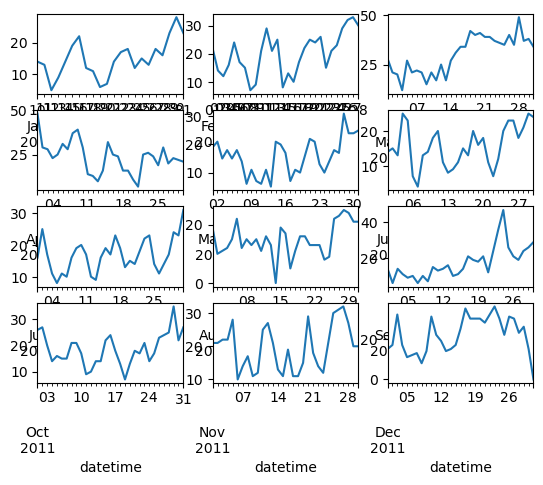

In [41]:
fig, axes = plt.subplots(nrows=4, ncols=3)

df_train.loc['2011-01-10':'2011-01-31', 'y'].plot(kind='line', ax=axes[0,0])
df_train.loc['2011-02-01':'2011-02-28', 'y'].plot(kind='line', ax=axes[0,1])
df_train.loc['2011-03-01':'2011-03-31', 'y'].plot(kind='line', ax=axes[0,2])
df_train.loc['2011-04-01':'2011-04-30', 'y'].plot(kind='line', ax=axes[1,0])
df_train.loc['2011-05-01':'2011-05-31', 'y'].plot(kind='line', ax=axes[1,1])
df_train.loc['2011-06-01':'2011-06-30', 'y'].plot(kind='line', ax=axes[1,2])
df_train.loc['2011-07-01':'2011-07-31', 'y'].plot(kind='line', ax=axes[2,0])
df_train.loc['2011-08-01':'2011-08-31', 'y'].plot(kind='line', ax=axes[2,1])
df_train.loc['2011-09-01':'2011-09-30', 'y'].plot(kind='line', ax=axes[2,2])
df_train.loc['2011-10-01':'2011-10-31', 'y'].plot(kind='line', ax=axes[3,0])
df_train.loc['2011-11-01':'2011-11-30', 'y'].plot(kind='line', ax=axes[3,1])
df_train.loc['2011-12-01':'2011-12-31', 'y'].plot(kind='line', ax=axes[3,2])

<AxesSubplot:xlabel='datetime'>

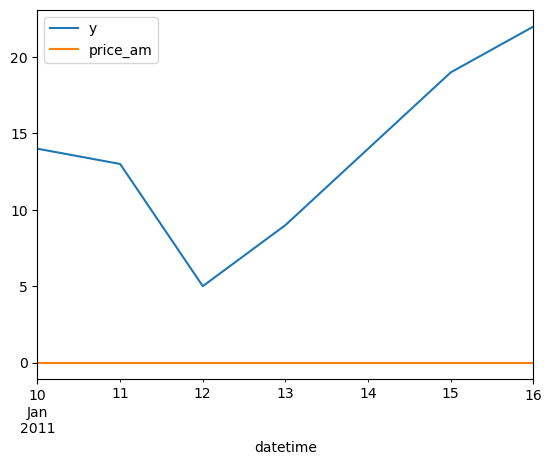

In [47]:
df_train.loc['2011-01-10':'2011-01-16', ['y', 'price_am']].plot(kind='line')

<AxesSubplot:xlabel='datetime'>

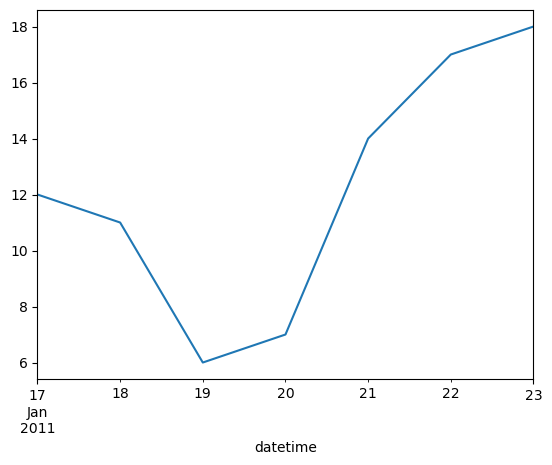

In [44]:
df_train.loc['2011-01-17':'2011-01-23', 'y'].plot(kind='line')

In [ ]:
# import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from time import time
import jpholiday
import datetime as dt
import sklearn.metrics as metrics
from dateutil.relativedelta import relativedelta
from scipy.stats import skew
from scipy.stats import kurtosis
import itertools
from prophet.diagnostics import cross_validation

def features_create_for_y(y_data, src):  
    holiday = jpholiday.between(dt.date(2010, 7, 1), dt.date(2017, 3, 31))
    holiday = [x[0] for x in holiday]
    data = src.copy()
    #tiansha = [dt.date(2010, 8, 26), dt.date(2010, 10, 25), dt.date(2010, 11, 10),
    #           dt.date(2011, 1, 9), dt.date(2011, 3, 24), dt.date(2011, 3, 24),
    #           dt.date(2011, 6, 8)]

    # normal features
    #data['Year'] = data.index.year
    data['Month'] = data.index.month
    #data['Day'] = data.index.day
    #data['DayOfWeek'] = data.index.dayofweek
    data['WeekOfYear'] = data.index.isocalendar().week
    data['DayOfYear'] = data.index.dayofyear
    #data['Quarter'] = data.index.quarter
    #data['JpHoliday'] = [1 if d.date() in holiday else 0 for d in data.index]

    #for i in data.index:
    #    if data.loc[i, 'DayOfWeek'] == 5 or data.loc[i, 'DayOfWeek'] == 6:
    #        data.loc[i, 'JpHoliday'] = 1

    from qreki import Kyureki
    for i in data.index:
        k = Kyureki.from_date(i)
        if (k.rokuyou == '大安'):
            data.loc[i, 'Kyureki'] = 1
        elif (k.rokuyou == '赤口'):
            data.loc[i, 'Kyureki'] = 2
        elif (k.rokuyou == '先勝'):
            data.loc[i, 'Kyureki'] = 3
        elif (k.rokuyou == '友引'):
            data.loc[i, 'Kyureki'] = 4
        elif (k.rokuyou == '先負'):
            data.loc[i, 'Kyureki'] = 5
        else: # 仏滅
            data.loc[i, 'Kyureki'] = 0

    moving_info = pd.read_csv('moving_info.csv', low_memory=False, index_col='datetime', parse_dates=True)
    for i in data.index:
        for j in moving_info.index:
            if i.year == j.year and i.month == j.month:
                data.loc[i, 'saitama'] = np.log(moving_info.loc[j, 'saitama'])
                data.loc[i, 'chiba'] = np.log(moving_info.loc[j, 'chiba'])
                data.loc[i, 'tokyo'] = np.log(moving_info.loc[j, 'tokyo'])
                data.loc[i, 'kanagawa'] = np.log(moving_info.loc[j, 'kanagawa'])
                data.loc[i, 'osaka'] = np.log(moving_info.loc[j, 'osaka'])

    # features for time series
    #data = features_add_current_for_y(y_data, data)
    #weather = pd.read_csv("./weather.csv", low_memory=False, index_col='datetime', parse_dates=True)
    #data['saitama'] = weather['saitama']
    #data['kanagawa'] = weather['kanagawa']
    #data['tokyo'] = weather['tokyo']
    #data['chiba'] = weather['chiba']
    # features for time series
    data.sort_values(['datetime'],ascending = True, inplace=True)
    
    return data

from prophet import Prophet

def tune_params():
    train = pd.read_csv("./train_repaired.csv", low_memory=False, parse_dates=[0])
    test = pd.read_csv("./test.csv", low_memory=False, parse_dates=[0])
    train = train.astype({"y": float})
    train.set_index('datetime', inplace=True)
    test.set_index('datetime', inplace=True)
    train = features_create_for_y(train, train)
    test = features_create_for_y(train, test)

    import jpholiday
    
    jholiday = jpholiday.between(dt.date(2010, 7, 1), dt.date(2017, 3, 31))
    jholiday = [x[0] for x in jholiday]
    holidays = []
    holiday_names = []
    for i in train.index:
        if i in jholiday:
            holidays.append(i)
            holiday_names.append('jpholiday')
        elif i.dayofweek == 5 or i.dayofweek == 6:
            holidays.append(i)
            holiday_names.append('weekend')
    holidays = pd.DataFrame({
        'holiday': holiday_names,
        'ds': holidays,
        'lower_window': 0,
        'upper_window': 1,
    })

    train.reset_index(inplace=True)
    train = train.rename(columns={'datetime': 'ds'}, inplace=True)
    train['cap']=95
    train['floor']=0

    # fit_model
    m=Prophet(
        holidays=holidays,
        holidays_prior_scale=6.6, #祝日効果の強さをいじるパラメータ
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        growth = 'logistic',
        changepoint_prior_scale=0.181,
        changepoint_range=0.822,
        n_changepoints=25,
        seasonality_prior_scale=24.5, 
        seasonality_mode='multiplicative'
      )
    m.add_seasonality(name='yearly', period=365.25, fourier_order=18,prior_scale=16.501, mode='multiplicative')
    #m.add_seasonality(name='monthly', period=28.5, fourier_order=4,prior_scale=0.001, mode='multiplicative')
    m.add_seasonality(name='weekly', period=7, fourier_order=4,prior_scale=19.001)
    m.add_seasonality(name='quaterly', period=365.25/4, fourier_order=9,prior_scale=3.501)
    m.add_regressor(name='client', prior_scale=10.0)
    m.add_regressor(name='close', prior_scale=14.0)
    m.add_regressor(name='price_am', prior_scale=5.501)
    m.add_regressor(name='price_pm', prior_scale=13.001)
    m.add_regressor(name='Month', prior_scale=46.5)
    m.add_regressor(name='DayOfYear', prior_scale=33.5)
    m.add_regressor(name='Kyureki', prior_scale=20.5)
    m.add_regressor(name='saitama', prior_scale=16.0)
    m.add_regressor(name='chiba', prior_scale=9.0)
    m.add_regressor(name='tokyo', prior_scale=22.0)
    m.add_regressor(name='kanagawa', prior_scale=7.5)
    m.fit(train)
    
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
    from prophet.diagnostics import performance_metrics
    df_cv = performance_metrics(df_cv)
    df_cv.to_csv('valid_result.csv', index=False, header=True)
    from prophet.plot import plot_cross_validation_metric
    plot_cross_validation_metric(df_cv, metric='mae')


/tmp/ipykernel_3577369/2894955508.py:95: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if i in jholiday:
22:25:21 - cmdstanpy - INFO - Chain [1] start processing
22:25:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

22:25:22 - cmdstanpy - INFO - Chain [1] start processing
22:25:22 - cmdstanpy - INFO - Chain [1] done processing
22:25:22 - cmdstanpy - INFO - Chain [1] start processing
22:25:22 - cmdstanpy - INFO - Chain [1] done processing
22:25:23 - cmdstanpy - INFO - Chain [1] start processing
22:25:23 - cmdstanpy - INFO - Chain [1] done processing
22:25:24 - cmdstanpy - INFO - Chain [1] start processing
22:25:24 - cmdstanpy - INFO - Chain [1] done processing
22:25:25 - cmdstanpy - INFO - Chain [1] start processing
22:25:25 - cmdstanpy - INFO - Chain [1] done processing
22:25:26 - cmdstanpy - INFO - Chain [1] start processing
22:25:26 - cmdstanpy - INFO - Chain [1] done processing


KeyError: 'ds'

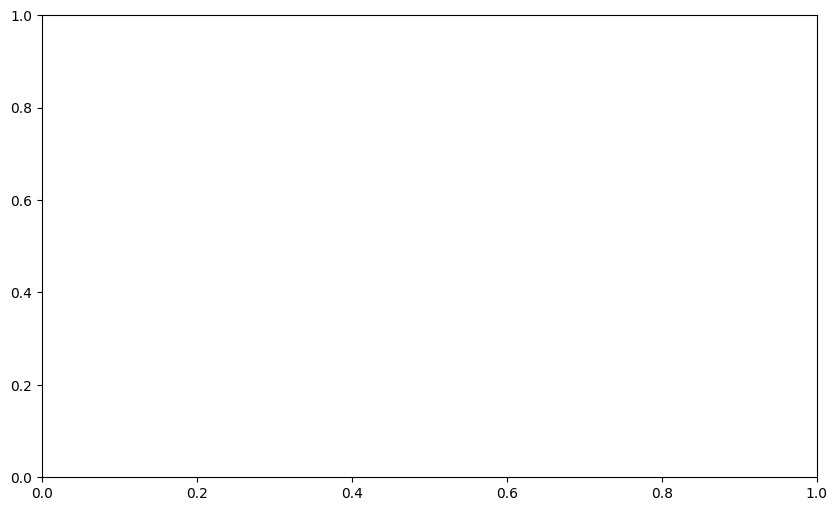

In [2]:
tune_params()